<a href="https://colab.research.google.com/github/djmary-k/Py17DS_HW10/blob/main/Hw10_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 10 part 01
## Convolutional Neural Networks & Residual Neural Network

В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras import optimizers, losses
from sklearn.metrics import classification_report
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# В якості згорткової основи скористаємося мережею VGG16, яка була навчена на даних ImageNet
# Імпортуємо модель, щоб створити основу згортки на базі VGG16
conv_vgg16_base = VGG16(include_top=False, input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [3]:
#  Розширюємо модель, додавши кастомні повнозвʼязні шари
# Для того, щоб модель адекватно навчалась на даному датасеті
conv_vgg16_base.trainable = False

model = Sequential([
   conv_vgg16_base,

   Flatten(),
   Dense(512, activation='relu'),
   Dropout(0.1),
   Dense(10, activation="softmax"),
])

In [4]:
# Після додавання верхніх шарів компілюємо модель, вказавши оптимізатор, функцію втрат і метрики
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [5]:
# Виведем опис архітектури моделі
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 267786 (1.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Як бачимо, в нас 14714688 не тренерованих параметрів, які ми відключили шляхов додавання рядку conv_vgg16_base.trainable = False

In [6]:
# Підготуємо дані
# Завантажуємо датасет і подивимось на його вміст
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

4422102/4422102 [==============================] - 1s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [7]:
# Зберігаємо назви класів
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

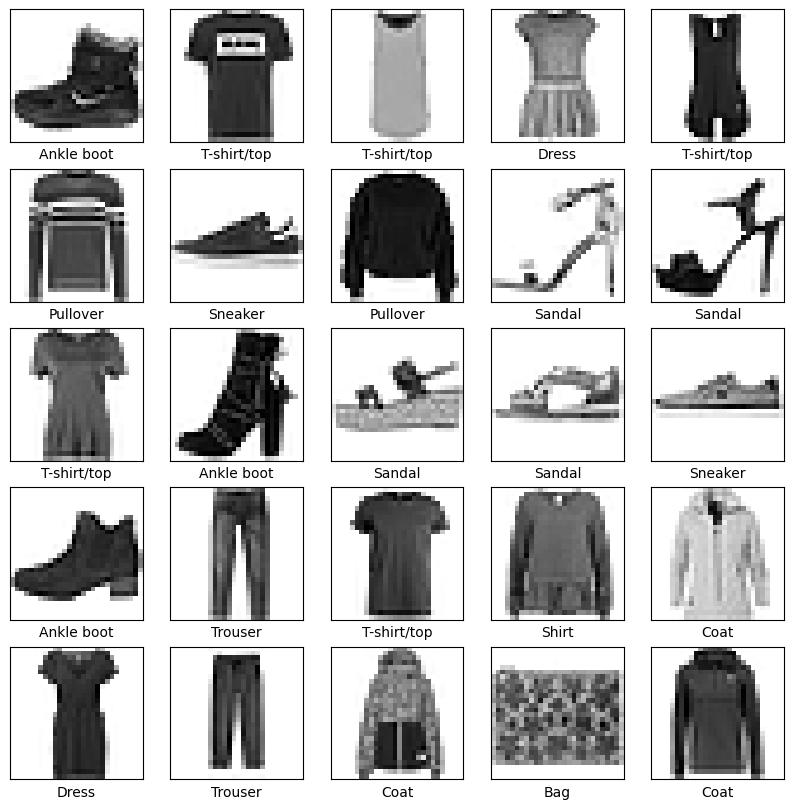

In [8]:
# Виведемо перші 25 зображень з навчальної вибірки, щоб переконатись що дані в правильному форматі
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

На даному етапі потрібно попрацювати з даними і підготувати їх для навчання.

Дана попередньонавчена згорткова VGG16 модель по-нормальному повинна приймати зображення у форматі 150x150 або 224x224 пікселів.
Але по ресурсам памʼяті ми не можемо перевести у розмір 150х150. Мінімальний формат, який приймає наша VGG16 це 32х32х3. Для цього переведемо наш формат 28х28х1 на 32х32х3 як ми задали параметр вхідного формату при імпорті даної моделі. Також потрібно змінити зображення з одного кольорового каналу (чорно-білі) на три кольорові канали:

In [9]:
train_images_rgb = np.repeat(x_train[..., np.newaxis], 3, axis=3)
test_images_rgb = np.repeat(x_test[..., np.newaxis], 3, axis=3)

In [10]:
train_images = np.array([np.resize(img, (32, 32, 3)) for img in train_images_rgb])
test_images = np.array([np.resize(img, (32, 32, 3)) for img in test_images_rgb])

In [11]:
# Нормалізуємо дані
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [12]:
# Навчання моделі на тренувальній вибірці
history = model.fit(train_images, y_train, epochs=40, batch_size=128, validation_split=0.2)

Epoch 1/40
375/375 [==============================] - 10s 12ms/step - loss: 1.3222 - accuracy: 0.5689 - val_loss: 0.9834 - val_accuracy: 0.6764
Epoch 2/40
375/375 [==============================] - 3s 8ms/step - loss: 0.9122 - accuracy: 0.6919 - val_loss: 0.8424 - val_accuracy: 0.7119
Epoch 3/40
375/375 [==============================] - 3s 8ms/step - loss: 0.8177 - accuracy: 0.7209 - val_loss: 0.7776 - val_accuracy: 0.7313
Epoch 4/40
375/375 [==============================] - 3s 8ms/step - loss: 0.7638 - accuracy: 0.7361 - val_loss: 0.7355 - val_accuracy: 0.7445
Epoch 5/40
375/375 [==============================] - 3s 9ms/step - loss: 0.7271 - accuracy: 0.7476 - val_loss: 0.7070 - val_accuracy: 0.7518
Epoch 6/40
375/375 [==============================] - 3s 9ms/step - loss: 0.7020 - accuracy: 0.7547 - val_loss: 0.6842 - val_accuracy: 0.7601
Epoch 7/40
375/375 [==============================] - 3s 8ms/step - loss: 0.6799 - accuracy: 0.7601 - val_loss: 0.6734 - val_accuracy: 0.7588
Epoc

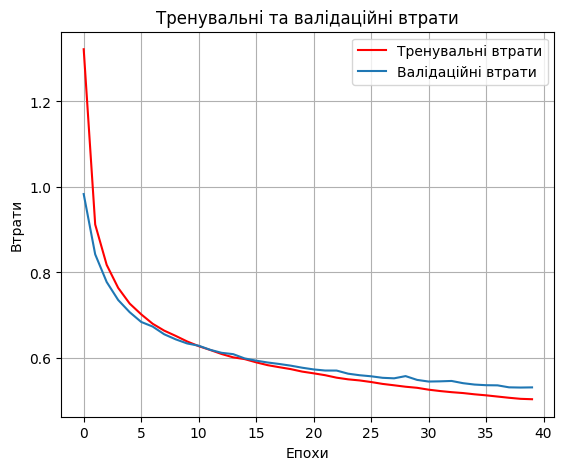

In [13]:
# Візуалізація отриманих даних
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні втрати', color='red')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title('Тренувальні та валідаційні втрати')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()


plt.show()

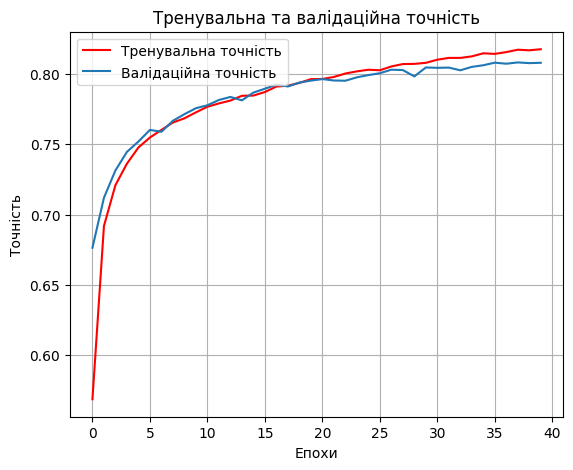

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна точність', color='red')
plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
plt.title('Тренувальна та валідаційна точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()

plt.show()

Отже, 82% тренувальна точність та 81% валідаційна точність є доволі не поганим результатом, але не найкращим. Можливо потрібно вказати більше епох.

Також можна покращувати модель застосувавши аугментацію для тренувальних даних, так як аугментація створює більш різноманітний тренувальний набір.

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator()

In [16]:
# Використовуємо .flow() метод для створення генераторів
train_generator = train_datagen.flow(
        train_images,
        y_train,
        batch_size=128)

validation_generator = test_datagen.flow(
        test_images,
        y_test,
        batch_size=128)

In [17]:
# Навчання моделі з використанням генераторів, які задали вище
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 256,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(test_images) // 256
)

Epoch 1/50
234/234 [==============================] - 20s 83ms/step - loss: 0.9245 - accuracy: 0.6736 - val_loss: 0.7671 - val_accuracy: 0.7264
Epoch 2/50
234/234 [==============================] - 21s 91ms/step - loss: 0.8089 - accuracy: 0.7055 - val_loss: 0.7715 - val_accuracy: 0.7266
Epoch 3/50
234/234 [==============================] - 20s 87ms/step - loss: 0.7839 - accuracy: 0.7136 - val_loss: 0.7704 - val_accuracy: 0.7310
Epoch 4/50
234/234 [==============================] - 19s 81ms/step - loss: 0.7739 - accuracy: 0.7168 - val_loss: 0.7312 - val_accuracy: 0.7416
Epoch 5/50
234/234 [==============================] - 20s 85ms/step - loss: 0.7627 - accuracy: 0.7224 - val_loss: 0.7381 - val_accuracy: 0.7430
Epoch 6/50
234/234 [==============================] - 20s 84ms/step - loss: 0.7540 - accuracy: 0.7248 - val_loss: 0.7819 - val_accuracy: 0.7308
Epoch 7/50
234/234 [==============================] - 20s 85ms/step - loss: 0.7461 - accuracy: 0.7258 - val_loss: 0.7557 - val_accuracy:

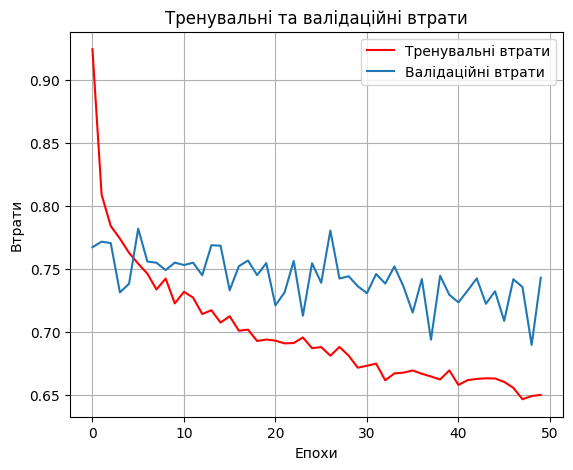

In [18]:
# Візуалізація отриманих даних
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні втрати', color='red')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title('Тренувальні та валідаційні втрати')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()


plt.show()

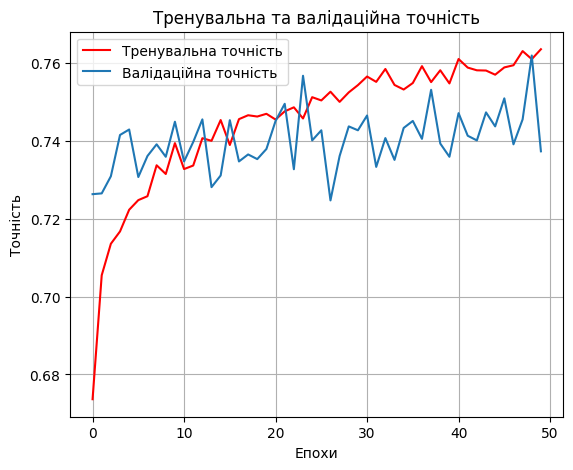

In [19]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна точність', color='red')
plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
plt.title('Тренувальна та валідаційна точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()

plt.show()

Можна зробити висновок, що дана модель перенавчилась. Точність на тренувальній вибірці стала гіршою - 76%. А отже, аугментація не допомогла покращити дану модель.

Спробуємо донавчити модель, розморозивши частину частину згорткової основи, а саме останні 4 згорткових шари моделі VGG16.

In [20]:
conv_vgg16_base = VGG16(include_top=False, input_shape=(32, 32, 3))

In [21]:
for layer in conv_vgg16_base.layers[:-4]:
    layer.trainable = False
for layer in conv_vgg16_base.layers[-4:]:
    layer.trainable = True

In [22]:

model = Sequential([
   conv_vgg16_base,

   Flatten(),
   Dense(512, activation='relu'),
   Dropout(0.2),
   Dense(10, activation="softmax"),
])

In [23]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 7347210 (28.03 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [25]:
history = model.fit(train_images, y_train, epochs=40, batch_size=128, validation_split=0.2)

Epoch 1/40
375/375 [==============================] - 7s 12ms/step - loss: 1.0601 - accuracy: 0.6330 - val_loss: 0.6693 - val_accuracy: 0.7697
Epoch 2/40
375/375 [==============================] - 5s 13ms/step - loss: 0.6432 - accuracy: 0.7713 - val_loss: 0.5653 - val_accuracy: 0.7990
Epoch 3/40
375/375 [==============================] - 4s 11ms/step - loss: 0.5593 - accuracy: 0.7977 - val_loss: 0.5174 - val_accuracy: 0.8158
Epoch 4/40
375/375 [==============================] - 4s 11ms/step - loss: 0.5147 - accuracy: 0.8137 - val_loss: 0.4962 - val_accuracy: 0.8208
Epoch 5/40
375/375 [==============================] - 4s 12ms/step - loss: 0.4841 - accuracy: 0.8254 - val_loss: 0.4634 - val_accuracy: 0.8314
Epoch 6/40
375/375 [==============================] - 4s 12ms/step - loss: 0.4635 - accuracy: 0.8324 - val_loss: 0.4461 - val_accuracy: 0.8379
Epoch 7/40
375/375 [==============================] - 4s 11ms/step - loss: 0.4426 - accuracy: 0.8394 - val_loss: 0.4498 - val_accuracy: 0.8348

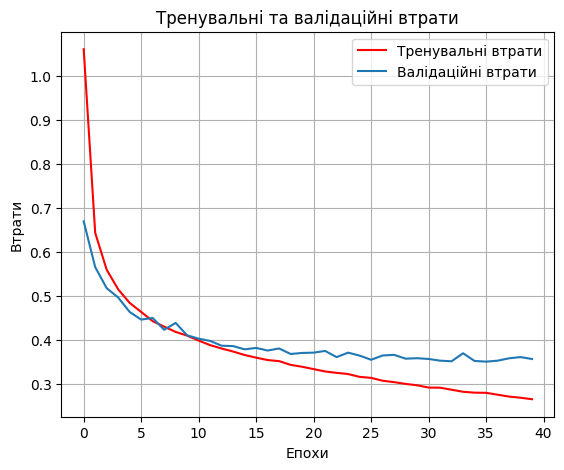

In [26]:
# Візуалізація отриманих даних
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні втрати', color='red')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title('Тренувальні та валідаційні втрати')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()


plt.show()

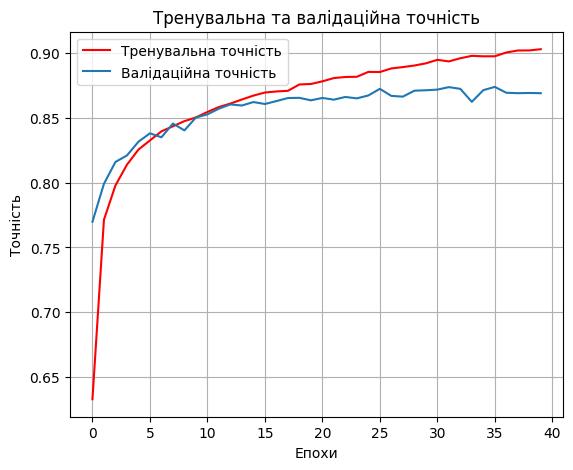

In [27]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна точність', color='red')
plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
plt.title('Тренувальна та валідаційна точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()

plt.show()

Як бачимо, що при донавчанні мережа показала кращі результати, а саме 90% точності. Тому можна зробити висновок, що саме донавчання виявилось найкращим варіантом для роботи з датасетом fashion_mnist через згорткову нейронну мережу VGG16.

Оцінимо модель.

Перед тим, як оцінити модель на тестовій вибірці, перетворимо її у розмір зображень 32х32х3.

In [28]:
x_test_resized = np.array([np.resize(img, (32, 32)) for img in x_test])
x_test_rgb = np.repeat(x_test_resized[..., np.newaxis], 3, axis=-1)

In [29]:
# # Нормалізуємо дані
x_test_rgb = x_test_rgb.astype('float32') / 255.

In [30]:
# Оцінка моделі на тестовій вибірці
test_loss, test_accuracy = model.evaluate(x_test_rgb, y_test, verbose=2)

print(f"Тестова втрата: {test_loss}")
print(f"Тестова точність: {test_accuracy}")

313/313 - 2s - loss: 0.3669 - accuracy: 0.8704 - 2s/epoch - 6ms/step
Тестова втрата: 0.3668695092201233
Тестова точність: 0.8704000115394592


Отже, в даному ДЗ було використано попередньо навчену модель VGG16. Завантаживщи дану згорткову нейронну мережу, було додано Flatten та 2 Dense шари. Отримано точність - 81%.

Далі зробивши аугментацію даних, на виході отримали гірший результат - 76% та перенавчання на валідаційних даних.

Потім було реалізовано донавчання, використувавши VGG16 розморозивши 4 останніх шари, отримавши точність 90%.

Після проведення оцінки моделі на тестовому датасеті отримано точність 87% та тестову втрату 0,36.